# Part 1: Training a Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-12-09 19:02:20.616110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

In [3]:
input_train = xr.open_dataset(os.path.join(train_path,'forcing_train.nc'))
input_test = xr.open_dataset(os.path.join(test_path,'forcing_test.nc'))

In [4]:
output_train = xr.open_dataset(os.path.join(train_path,'member_165_train.nc'))
output_test = xr.open_dataset(os.path.join(test_path,'member_165_test.nc'))

In [5]:
X_train_df = pd.DataFrame({"delta_T": input_train.delta_T.data},index=input_train.delta_T.coords['time'].data)

In [6]:
y_df_stack = output_train.velsurf_mag.stack(dim=["y", "x"])


In [7]:
y_df_stack

<xarray.DataArray 'velsurf_mag' (time: 300, dim: 145161)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * time     (time) float64 -1.149e+05 -1.148e+05 ... -8.5e+04 -8.49e+04
  * dim      (dim) object MultiIndex
  * y        (dim) float64 -3.04e+06 -3.04e+06 -3.04e+06 ... 3.04e+06 3.04e+06
  * x        (dim) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Attributes:
    long_name:    magnitude of horizontal velocity of ice at ice surface
    units:        m year-1
    pism_intent:  diagnostic

In [8]:
y_train_df = pd.DataFrame(y_df_stack.to_pandas())

In [9]:
y_train_df = y_train_df.fillna(-1)

In [10]:
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

In [11]:
print(X_train.shape,y_train.shape)

(300, 1) (300, 145161)


In [12]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true >=0]
    y_true = y_true[y_true >=0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [13]:
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.01
minibatch_size = 64
model_num      = 1

In [14]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 4th hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer


model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 145161)            9435465   
                                                                 
Total params: 9,448,073
Trainable params: 9,448,073
Non-trainable params: 0
_________________________________________________________________


In [16]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50


2022-12-09 19:02:57.511418: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 139354560 exceeds 10% of free system memory.
2022-12-09 19:02:57.684208: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 139354560 exceeds 10% of free system memory.
2022-12-09 19:02:58.508021: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37161216 exceeds 10% of free system memory.
2022-12-09 19:02:58.508074: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27870912 exceeds 10% of free system memory.
2022-12-09 19:02:58.509304: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37161216 exceeds 10% of free system memory.


4/4 [==============================] - 2s 110ms/step - loss: 195.6462 - val_loss: 149.5834
Epoch 2/50
4/4 [==============================] - 0s 36ms/step - loss: 193.9774 - val_loss: 143.7824
Epoch 3/50
4/4 [==============================] - 0s 39ms/step - loss: 184.6838 - val_loss: 123.9484
Epoch 4/50
4/4 [==============================] - 0s 37ms/step - loss: 159.3908 - val_loss: 131.4425
Epoch 5/50
4/4 [==============================] - 0s 37ms/step - loss: 137.5078 - val_loss: 111.8891
Epoch 6/50
4/4 [==============================] - 0s 36ms/step - loss: 118.9220 - val_loss: 106.6241
Epoch 7/50
4/4 [==============================] - 0s 37ms/step - loss: 113.8097 - val_loss: 121.2091
Epoch 8/50
4/4 [==============================] - 0s 36ms/step - loss: 110.7494 - val_loss: 107.4769
Epoch 9/50
4/4 [==============================] - 0s 37ms/step - loss: 107.7302 - val_loss: 108.4235
Epoch 10/50
4/4 [==============================] - 0s 38ms/step - loss: 106.1271 - val_loss: 112.4450

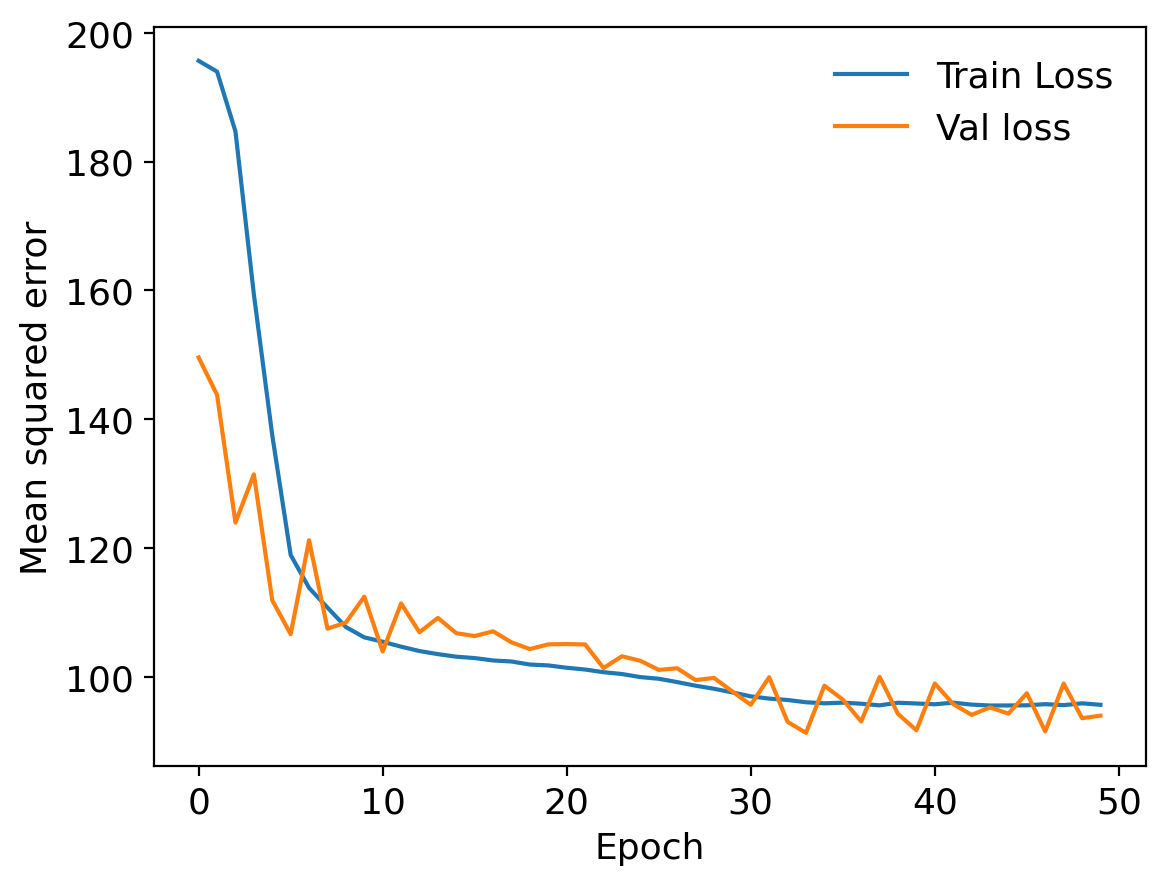

In [17]:
plot_history(history)

In [18]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [19]:
model.save(os.path.join(model_path,'NN_model_1_member.h5'))

## Testing

In [20]:
model = load_model(os.path.join(model_path,'NN_model_1_member.h5'),custom_objects={'custom_rmse':custom_rmse})

In [18]:
X_test_df = pd.DataFrame({"delta_T": input_test.delta_T.data},index=input_test.delta_T.coords['time'].data)

In [19]:
y_test_df = pd.DataFrame(output_test.velsurf_mag.stack(dim=["y", "x"]).to_pandas())

In [20]:
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

In [21]:
score = model.evaluate(X_test, y_test_df.fillna(-1).to_numpy(), verbose = 0) 


In [22]:
score

105.46984100341797

In [23]:
y_test_pre = model.predict(X_test)


4/4 [==============================] - 0s 2ms/step


In [24]:
y_test_pre_rs = y_test_pre.reshape(y_test_df.index.values.shape[0],y_test_df.columns.levels[1].shape[0],y_test_df.columns.levels[0].shape[0])

y_test_pre_xr = xr.Dataset(coords={'time': y_test_df.index.values, 
                               'x': y_test_df.columns.levels[1].values, 
                               'y': y_test_df.columns.levels[0].values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [25]:
y_test_pre_xr

<xarray.Dataset>
Dimensions:      (time: 100, y: 381, x: 381)
Coordinates:
  * time         (time) float64 -8.48e+04 -8.47e+04 ... -7.5e+04 -7.49e+04
  * x            (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y            (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    velsurf_mag  (time, y, x) float32 -2.398 -2.873 -1.536 ... 1.351 -0.7035

In [26]:
y_true =  y_test_df.unstack().to_xarray()

In [27]:
y_true

<xarray.DataArray (y: 381, x: 381, time: 100)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y        (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * x        (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * time     (time) float64 -8.48e+04 -8.47e+04 -8.46e+04 ... -7.5e+04 -7.49e+04

In [28]:
y_test_pre_xr = y_test_pre_xr+y_true-y_true

In [29]:
rmse_xr = np.sqrt(((y_true-y_test_pre_xr)**2).sum(dim=['x','y','time'])/y_true.count(dim=['x','y','time']))

In [30]:
rmse_xr

<xarray.Dataset>
Dimensions:      ()
Data variables:
    velsurf_mag  float64 106.0

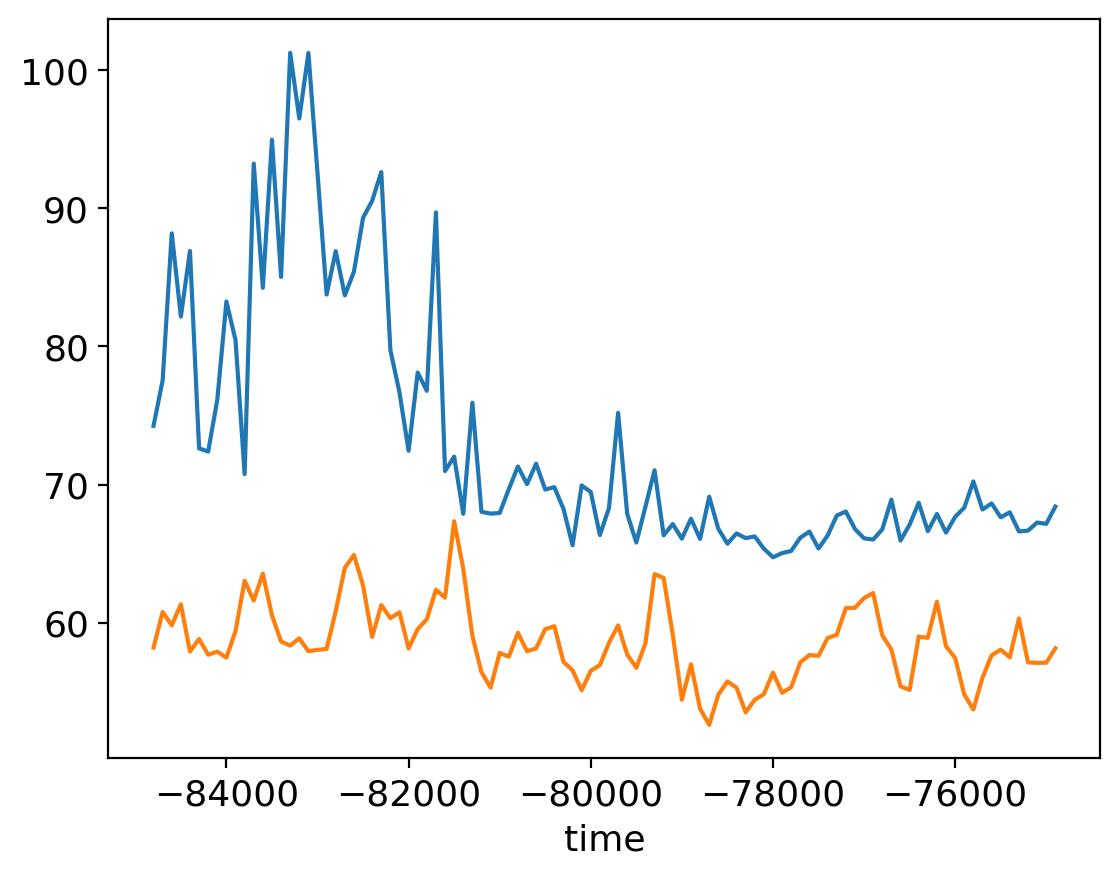

In [31]:
y_test_pre_xr.velsurf_mag.mean(dim=['x','y']).plot()
y_true.mean(dim=['x','y']).plot()

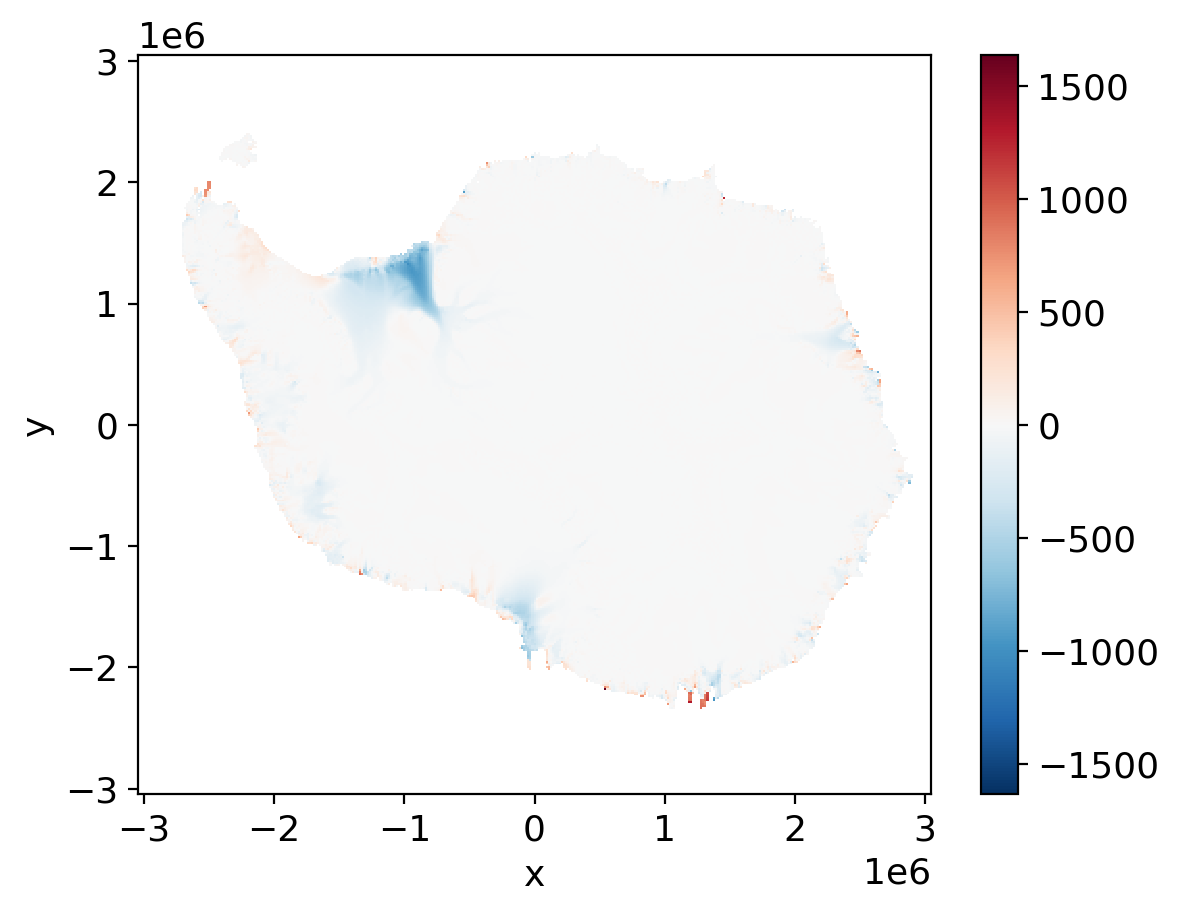

In [32]:
(y_true-y_test_pre_xr.velsurf_mag).mean(dim='time').plot()

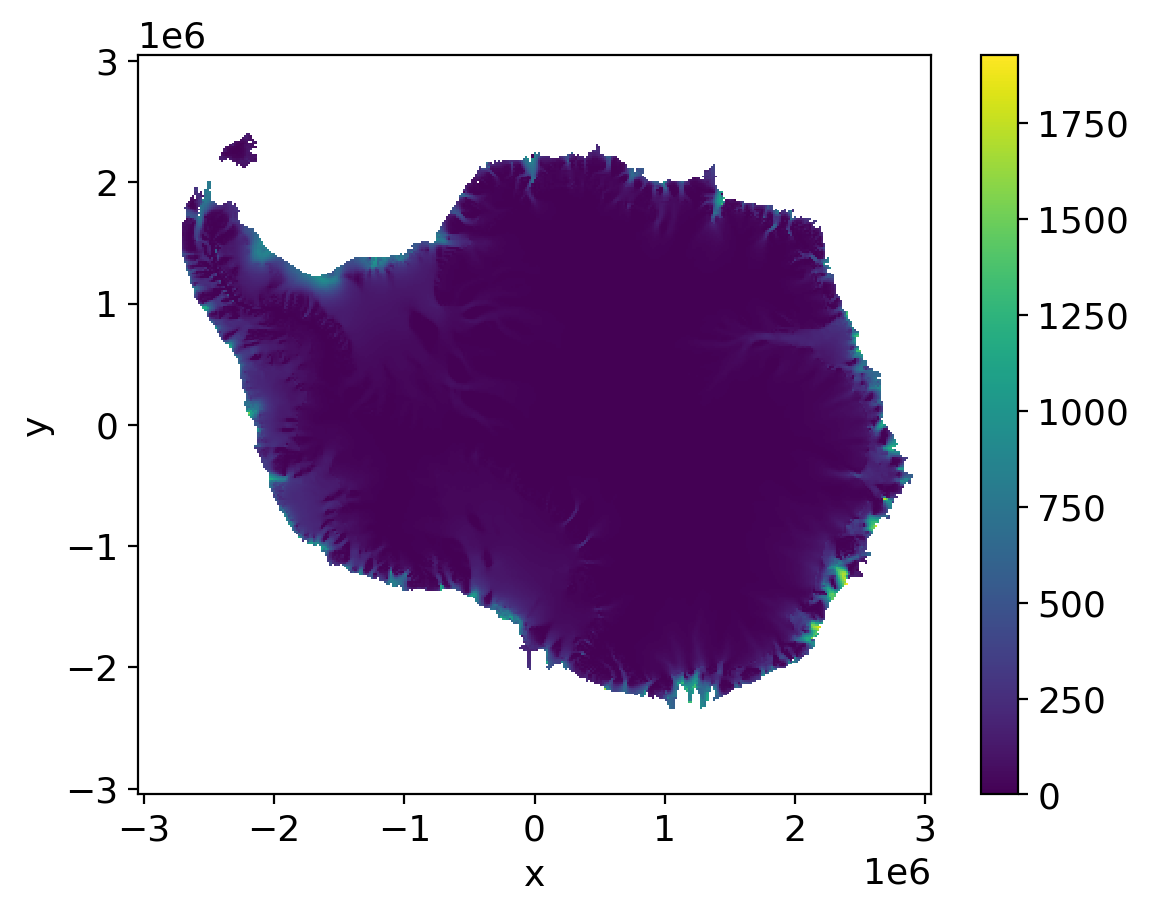

In [33]:
y_true.mean(dim='time').plot()

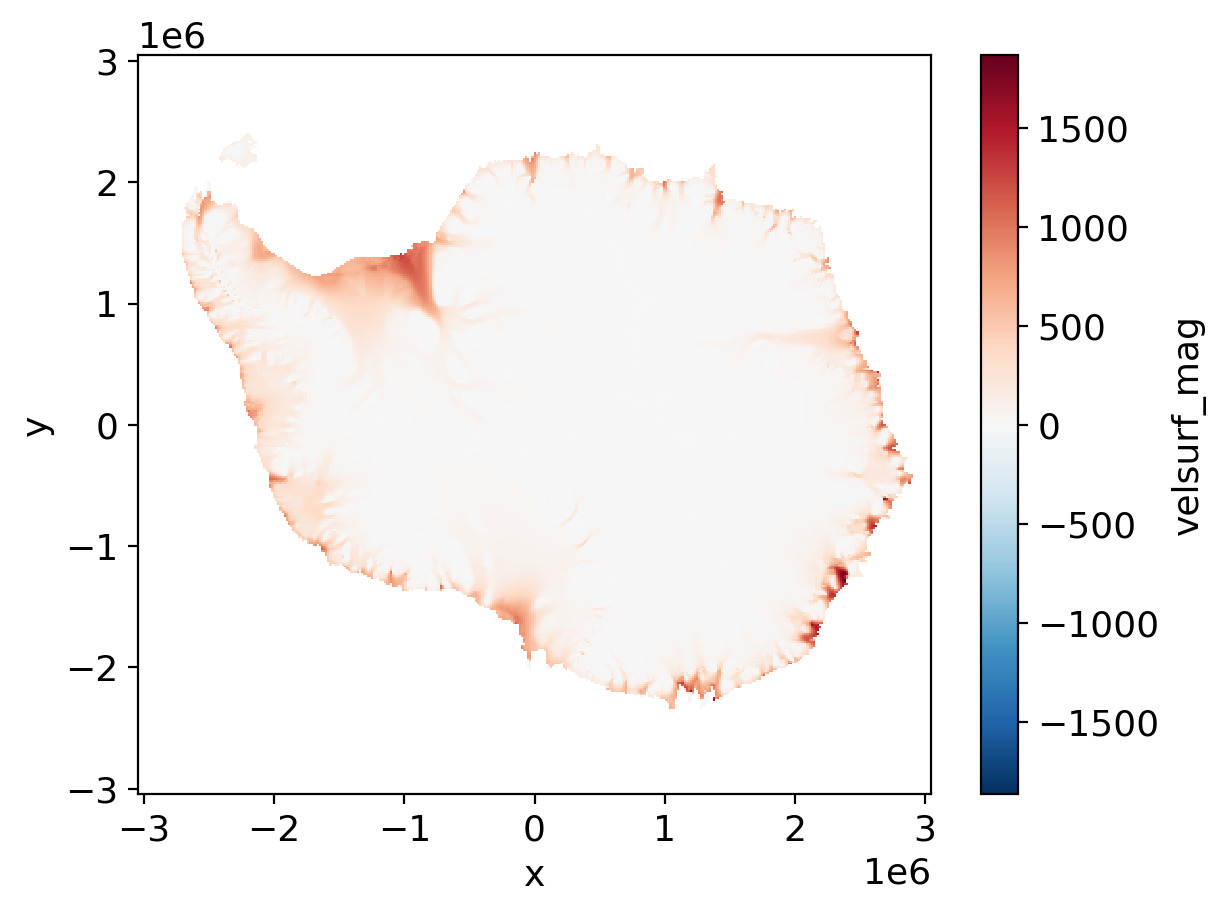

In [34]:
y_test_pre_xr.velsurf_mag.mean(dim='time').plot()

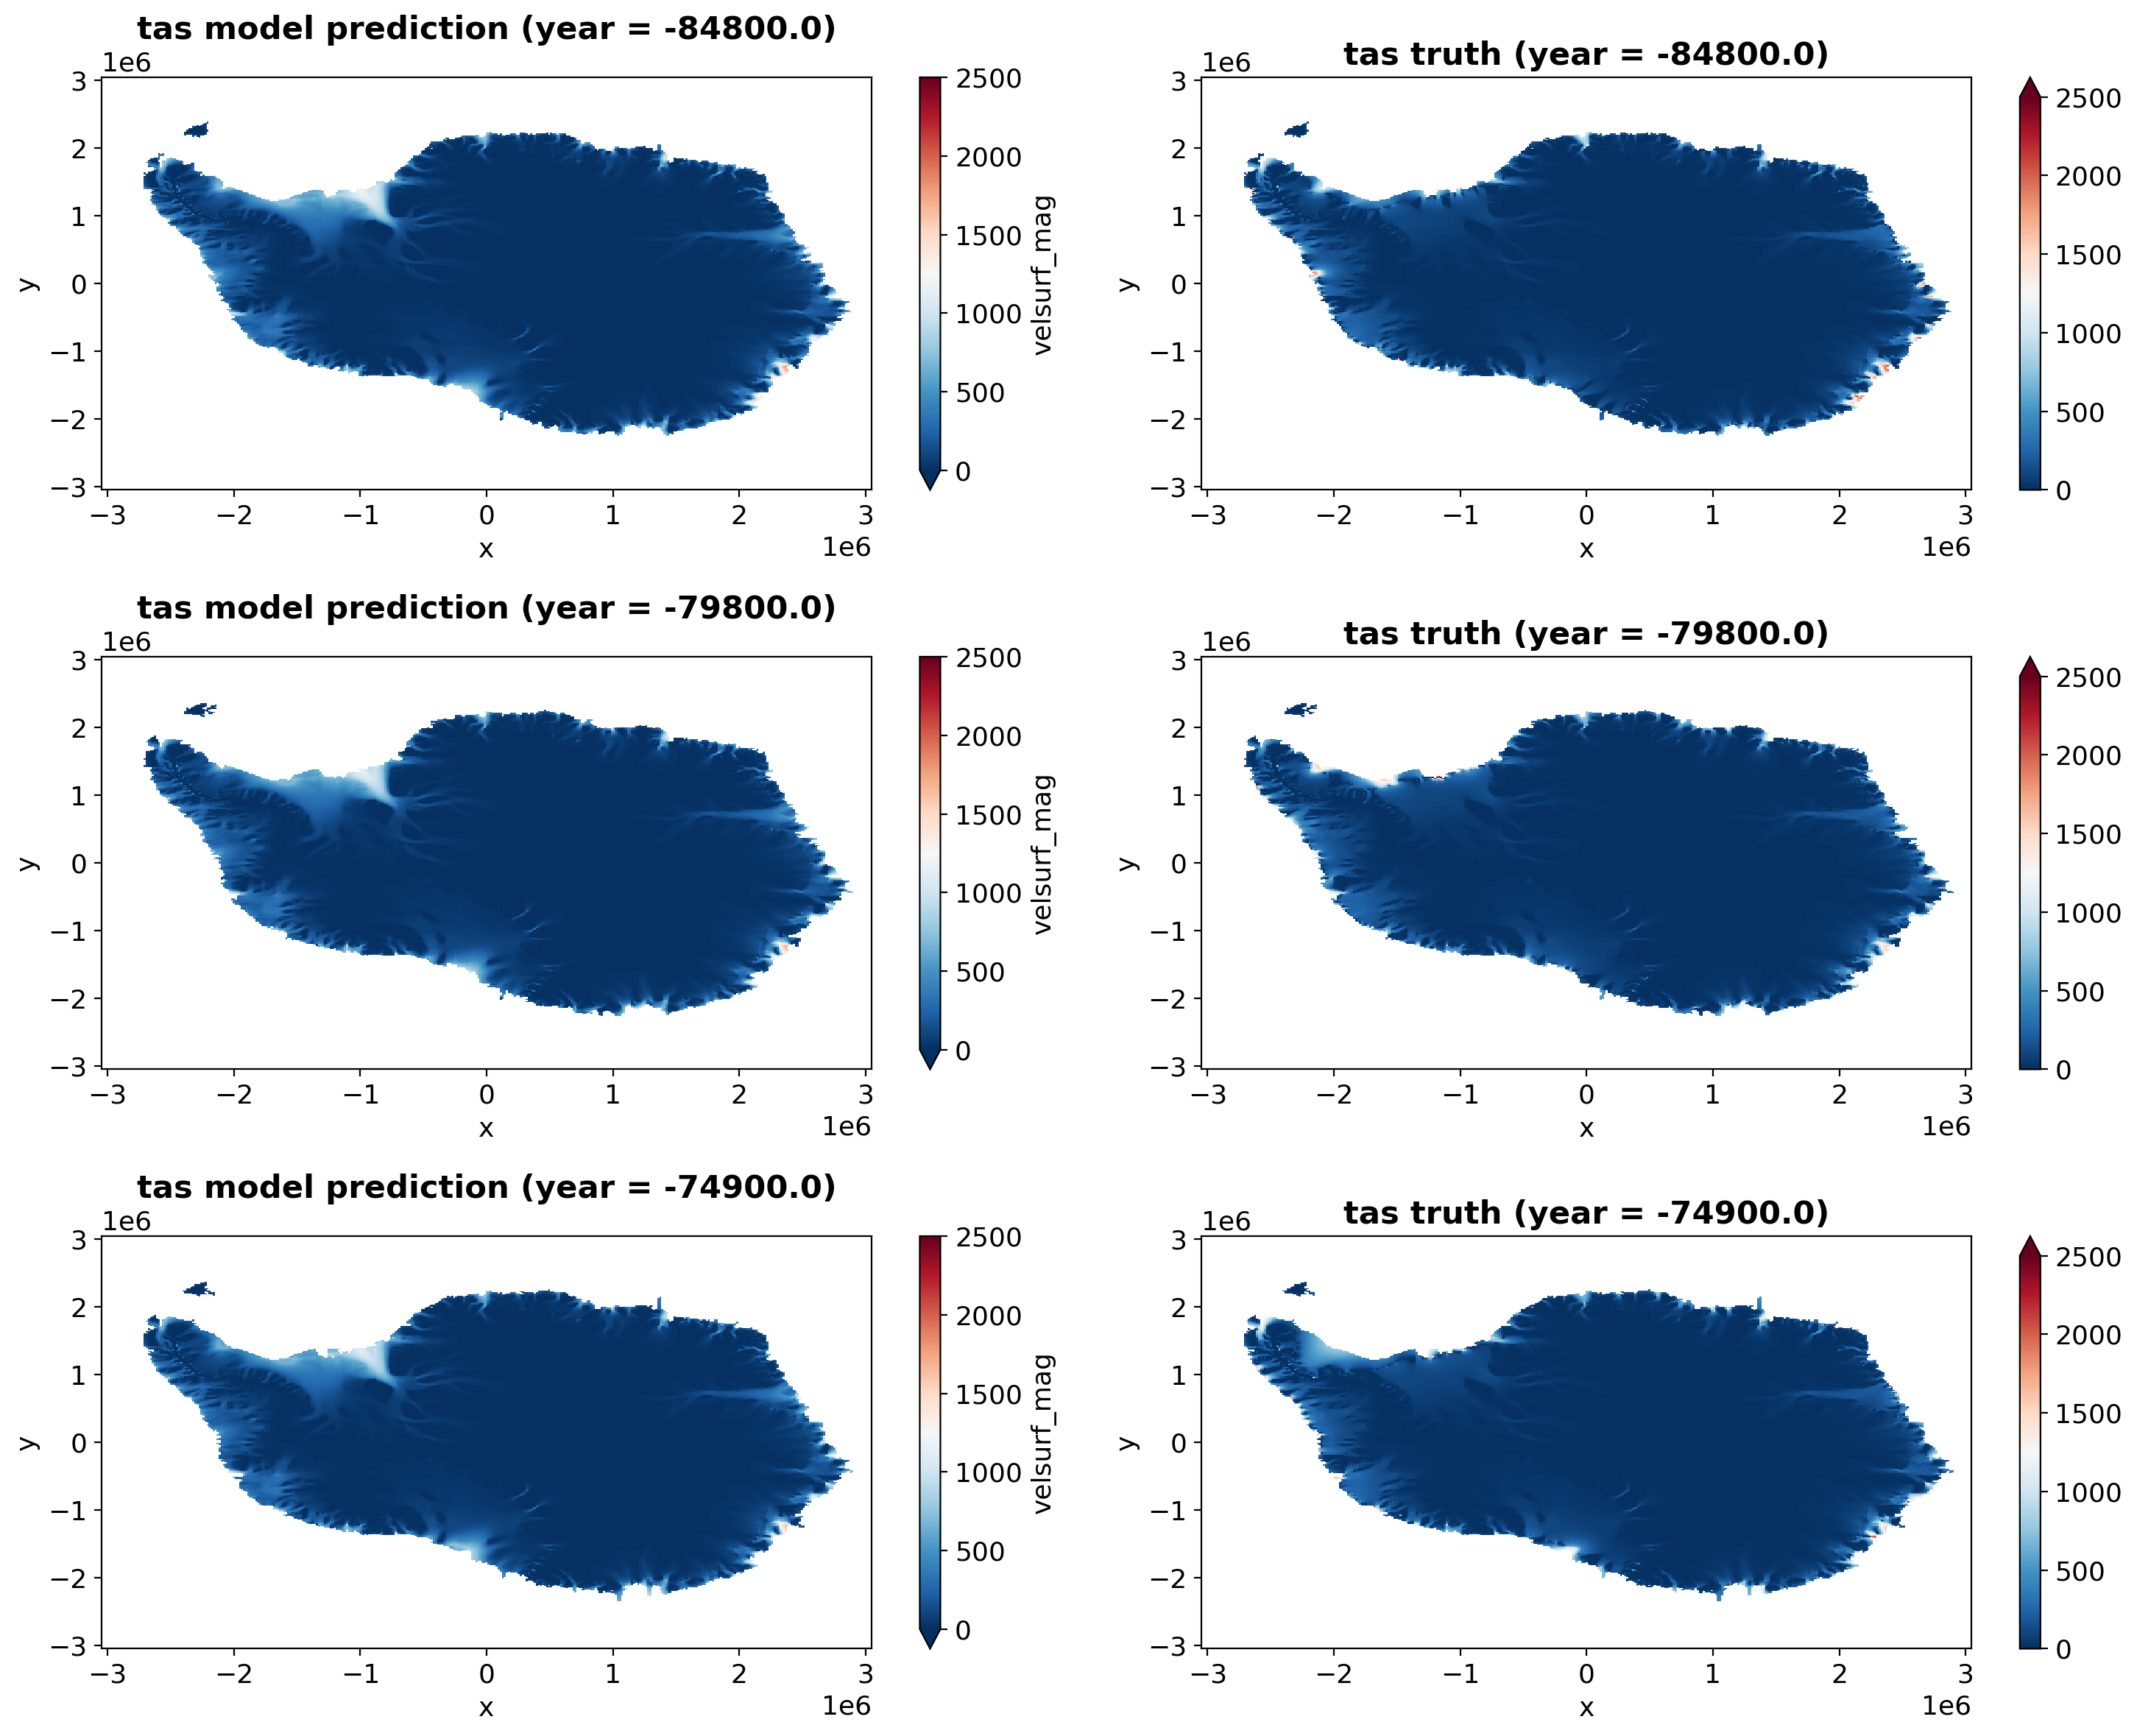

In [36]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [y_test_pre_xr.time[0].values, y_test_pre_xr.time[50].values, y_test_pre_xr.time[99].values]
vmin, vmax    = 0, 2500
cmap = 'RdBu_r'
y_test_pre_xr.velsurf_mag.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre_xr.velsurf_mag.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre_xr.velsurf_mag.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()